# Graph Neural Network

In [ ]:
%pip install torch_geometric

引入必要的包


In [2]:
# type: ignore
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 定义GCN模型
定义两层GCN结构   
使用Cora数据集, 每篇论文都由一个1433维的词向量表示，所以，每个样本点具有1433个特征。词向量的每个元素都对应一个词，且该元素只有0或1两个取值。

**词袋向量（Bag-of-Words）的解释**：
共有 1433 个单词（从所有论文的标题和摘要中提取的）, 每篇论文用一个 1433维的向量表示：
- 第 i 个位置是 1：代表第 i 个词出现在这篇论文中
- 第 i 个位置是 0：代表没出现
这种向量是稀疏的（大多数位置是 0）   

每篇论文都至少引用了一篇其他论文，或者被其他论文引用，也就是样本点之间存在联系，没有任何一个样本点与其他样本点完全没联系。如果将样本点看做图中的点，则这是一个连通的图，不存在孤立点。

In [3]:
# 1. 定义GCN模型
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        # 第一层GCN：输入特征 -> 隐藏层
        self.conv1 = GCNConv(num_features, hidden_dim)
        # 第二层GCN：隐藏层 -> 输出类别
        self.conv2 = GCNConv(hidden_dim, num_classes)
        # Dropout函数用来随机放弃神经元
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        # x: 节点特征矩阵 [num_nodes, num_features]
        # edge_index: 边索引 [2, num_edges]

        # 第一层：图卷积 + ReLU激活 + Dropout
        # GCN 第一层会将 1433维 映射成例如 16维（hidden_dim）
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        # 第二层：图卷积
        # 然后第二层会将 16维 映射成 7维（表示7个论文类别的 logits）
        x = self.conv2(x, edge_index)

        # 返回节点的类别预测（logits）
        return F.log_softmax(x, dim=1)

In [ ]:
# 2. 加载Cora数据集（学术论文引用网络）
# 下载到 'data/Cora' 目录
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

## 查看数据信息

In [5]:
# 正确的方式查看数据信息
print("=== Cora 数据集信息 ===")
print(f"数据对象: {data}")
print(f"\n节点数量: {data.num_nodes}")
print(f"边数量: {data.num_edges}")
print(f"节点特征维度: {data.num_node_features}")
print(f"类别数量: {dataset.num_classes}")

print(f"\n节点特征矩阵 x 的形状: {data.x.shape}")
print(f"边索引 edge_index 的形状: {data.edge_index.shape}")
print(f"节点标签 y 的形状: {data.y.shape}")
print(f"\n训练节点数: {data.train_mask.sum().item()}")
print(f"验证节点数: {data.val_mask.sum().item()}")
print(f"测试节点数: {data.test_mask.sum().item()}")

# 查看标签分布
print(f"\n每个类别的节点数:")
for i in range(dataset.num_classes):
    print(f"类别 {i}: {(data.y == i).sum().item()} 个节点")

=== Cora 数据集信息 ===
数据对象: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

节点数量: 2708
边数量: 10556
节点特征维度: 1433
类别数量: 7

节点特征矩阵 x 的形状: torch.Size([2708, 1433])
边索引 edge_index 的形状: torch.Size([2, 10556])
节点标签 y 的形状: torch.Size([2708])

训练节点数: 140
验证节点数: 500
测试节点数: 1000

每个类别的节点数:
类别 0: 351 个节点
类别 1: 217 个节点
类别 2: 418 个节点
类别 3: 818 个节点
类别 4: 426 个节点
类别 5: 298 个节点
类别 6: 180 个节点


# 创建模型

In [6]:
# 3. 创建模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(
    num_features=dataset.num_features,
    hidden_dim=16,
    num_classes=dataset.num_classes
).to(device)
data = data.to(device)

# 训练模型

In [ ]:
# 4. 训练模型
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    # 前向传播
    out = model(data.x, data.edge_index)
    # 计算损失（只在训练集上）
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    # 反向传播
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        # 获取预测结果
        logits = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)

        # 计算各个数据集的准确率
        accs = []
        for mask_name in ['train_mask', 'val_mask', 'test_mask']:
            mask = data[mask_name]
            correct = pred[mask] == data.y[mask]
            acc = correct.float().mean().item()
            accs.append(acc)
        return accs

# 训练循环

In [8]:
# 5. 训练循环
print("\n开始训练...")
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        train_acc, val_acc, test_acc = test()
        print(f'Epoch {epoch:3d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.3f}, Val: {val_acc:.3f}, Test: {test_acc:.3f}')


开始训练...
Epoch   0, Loss: 1.9527, Train: 0.629, Val: 0.398, Test: 0.421
Epoch  20, Loss: 0.2942, Train: 1.000, Val: 0.788, Test: 0.802
Epoch  40, Loss: 0.0738, Train: 1.000, Val: 0.778, Test: 0.800
Epoch  60, Loss: 0.0642, Train: 1.000, Val: 0.768, Test: 0.792
Epoch  80, Loss: 0.0452, Train: 1.000, Val: 0.776, Test: 0.794
Epoch 100, Loss: 0.0391, Train: 1.000, Val: 0.772, Test: 0.796
Epoch 120, Loss: 0.0476, Train: 1.000, Val: 0.782, Test: 0.807
Epoch 140, Loss: 0.0326, Train: 1.000, Val: 0.778, Test: 0.803
Epoch 160, Loss: 0.0437, Train: 1.000, Val: 0.778, Test: 0.807
Epoch 180, Loss: 0.0502, Train: 1.000, Val: 0.772, Test: 0.811


# 最终评估

In [9]:
# 6. 最终评估
train_acc, val_acc, test_acc = test()
print(f'\n最终结果:')
print(f'训练集准确率: {train_acc:.3f}')
print(f'验证集准确率: {val_acc:.3f}')
print(f'测试集准确率: {test_acc:.3f}')


最终结果:
训练集准确率: 1.000
验证集准确率: 0.772
测试集准确率: 0.808


# 可视化学习到的节点嵌入

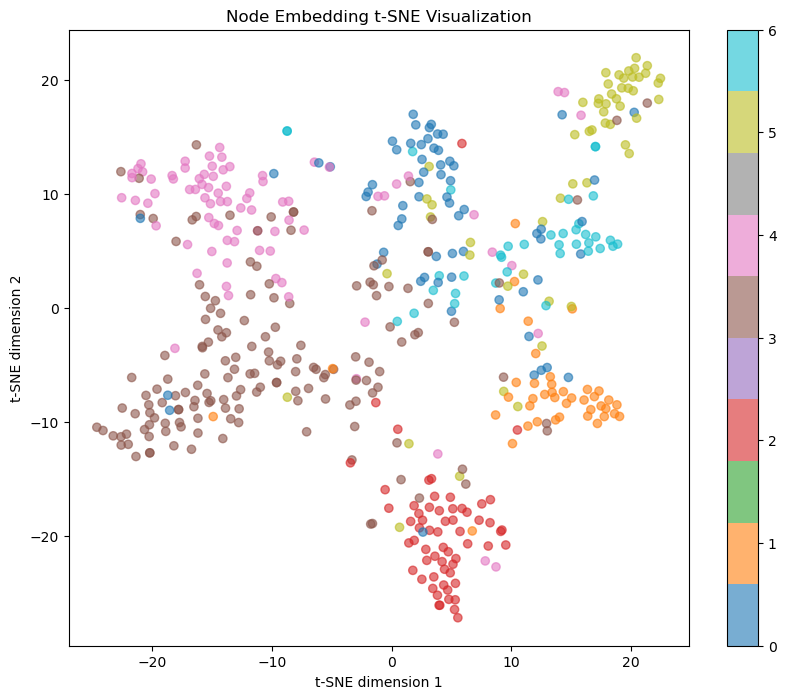

In [10]:
# 7. 可视化学习到的节点嵌入
model.eval()
with torch.no_grad():
    # 获取第一层的节点嵌入
    h = model.conv1(data.x, data.edge_index)
    h = F.relu(h)

    # 使用t-SNE降维到2D
    embeddings = h.cpu().numpy()
    labels = data.y.cpu().numpy()

    # 只可视化一部分节点以提高清晰度
    num_vis = 500
    indices = np.random.choice(len(embeddings), num_vis, replace=False)

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings[indices])

    # 绘制
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=labels[indices], cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Node Embedding t-SNE Visualization')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

# 简单示例
## 示例1: 展示消息传递过程

In [ ]:
print("\n消息传递示例（简化版）:")
# 创建一个小图
small_x = torch.tensor([[1.0], [2.0], [3.0], [4.0]])  # 4个节点
small_edges = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]], dtype=torch.long)  # 环形连接

print(f"初始节点特征: {small_x.squeeze().tolist()}")
print(f"边连接: 0->1, 1->2, 2->3, 3->0")


消息传递示例（简化版）:
初始节点特征: [1.0, 2.0, 3.0, 4.0]
边连接: 0->1, 1->2, 2->3, 3->0


## 简单的平均聚合
找到节点i的所有邻居是核心操作：
`edges[1] == i` 表示“所有指向节点 i 的边”, 对应的 edges[0] 就是那些邻居节点。   
比如：
```python
edges = [[0, 1, 2, 3],    # 源头
          [1, 2, 3, 0]]   # 目标
```
以第一次循环为例子来说，当 i=0，查 edges[1] == 0：找到最后一条边（3→0），所以 neighbors = [3]（即节点 0 的邻居是 3）。

In [20]:
# 简单的平均聚合
def simple_aggregate(x, edges):
    new_x = torch.zeros_like(x)
    for i in range(x.size(0)):
        # 找到节点i的所有邻居
        neighbors = edges[0][edges[1] == i]
        if len(neighbors) > 0:
            # 聚合邻居特征（这里用平均）
            new_x[i] = x[neighbors].mean()
        else:
            new_x[i] = x[i]
    return new_x

# 执行一步消息传递
new_features = simple_aggregate(small_x, small_edges)
print(f"一步传播后: {new_features.squeeze().tolist()}")
print("注意：每个节点现在包含了其邻居的信息！")

torch.Size([4, 1])
一步传播后: [4.0, 1.0, 2.0, 3.0]
注意：每个节点现在包含了其邻居的信息！


`[4.0, 1.0, 2.0, 3.0]` 这组新特征值，正是对应 节点编号 0, 1, 2, 3 的更新后特征。   
现在是完成了消息传递的一步，但还没完成“训练”，因为还没有计算损失、反向传播、更新参数，所以这只是 GNN 前向传播的一小步，不是训练完成。

## 示例2: 展示mean做邻居节点平均机制

In [12]:
import torch

print("\n消息传递示例（含多个邻居）:")

# 创建节点特征：4个节点，每个特征是标量
x = torch.tensor([[1.0], [2.0], [3.0], [4.0]])  # 节点0~3

# 构造边：让节点0有两个邻居（1 和 2），节点1也有两个邻居（0 和 3）
edge_index = torch.tensor([
    [1, 2, 0, 3],  # 源点（from）
    [0, 0, 1, 1]   # 终点（to）
], dtype=torch.long)

print(f"初始节点特征: {x.squeeze().tolist()}")
print("边连接（from → to）:")
for src, dst in zip(edge_index[0], edge_index[1]):
    print(f"  {src.item()} → {dst.item()}")


消息传递示例（含多个邻居）:
初始节点特征: [1.0, 2.0, 3.0, 4.0]
边连接（from → to）:
  1 → 0
  2 → 0
  0 → 1
  3 → 1


In [13]:
# 定义平均聚合函数
def mean_aggregate(x, edges):
    new_x = torch.zeros_like(x)
    for i in range(x.size(0)):
        neighbors = edges[0][edges[1] == i]  # 找到所有指向i的源节点
        if len(neighbors) > 0:
            new_x[i] = x[neighbors].mean(dim=0)  # 聚合邻居特征（平均）
        else:
            new_x[i] = x[i]  # 如果没有邻居，保持原样
    return new_x

# 执行一次消息传递
new_features = mean_aggregate(x, edge_index)
print(f"\n聚合后新特征: {new_features.squeeze().tolist()}")


聚合后新特征: [2.5, 2.5, 3.0, 4.0]
